# Introduction

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 120)

In [2]:
# Connecting to the database and creating cursor object
conn = sqlite3.connect("database.sqlite")
cursor = conn.cursor()

Displaying schema with the use of luna modeler 6.3.0

In [3]:
from IPython.display import IFrame, display

filepath = "SQLite.pdf"
IFrame(filepath, width=700, height=400)


# Explanatory Data Analysis

## Player

The player table will be fetched, initially described and cleaned. Then stored in the new table in the database. 

Reading in the table.

In [4]:
player = pd.read_sql("""select * from player """, conn, parse_dates='birthday')
player.head(2)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146


Getting the year of birthday.

In [5]:
player["birthday"] = player["birthday"].dt.year

Converting player's weight to kg. 

In [6]:
player["weight"] = player['weight'] / 2.20462262

Checking for missing values.

In [7]:
player.isnull().sum()

id                    0
player_api_id         0
player_name           0
player_fifa_api_id    0
birthday              0
height                0
weight                0
dtype: int64

Let's quickly check if we can remove player_fifa_api_id. That would be possible if there are no null values for player_api_id in player_attributes table. 

In [8]:
pd.read_sql('''select player_api_id from player_attributes where player_api_id is null''', conn)

,player_api_id


Dropping player_fifa_api_id.

In [9]:
player.drop(['id', 'player_fifa_api_id'], axis=1, inplace=True)

Although we expect that there may be some duplicates there won't be removed to prevent loosing data when joining. 

The duplicates will be remove only for the porpose of showing weight, height and birthday distribution. 

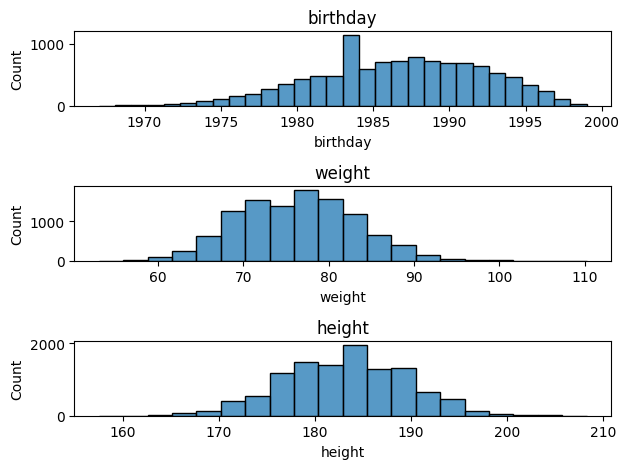

In [10]:
# Removing duplicates
player_without = player[~player[['player_name', 'birthday']].duplicated(keep=False)]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
sns.histplot(player_without, x="birthday", bins=30, ax=ax1)
ax1.set(title='birthday')
sns.histplot(player_without, x="weight", bins=20, ax=ax2)
ax2.set(title='weight')
sns.histplot(player_without, x="height", bins=20, ax=ax3)
ax3.set(title='height')
plt.tight_layout()

In [11]:
pd.set_option("display.float_format", "{:.2f}".format)
player_without[['birthday', 'height', 'weight']].describe()

,birthday,height,weight
count,11030.00,11030.00,11030.00
mean,1986.64,181.87,76.38
std,5.49,6.37,6.80
min,1967.00,157.48,53.07
25%,1983.00,177.80,72.12
50%,1987.00,182.88,76.20
75%,1991.00,185.42,81.19
max,1999.00,208.28,110.22


The distribution of birthday is univariate and slightly skewed to the left. There is one particular interesting year 1983 with over 1000 players born. The players are 180cm with 6cm standard deviations. They weight or average 76cm. We will be able to check if those numbers are differ signifficantly for particular teams.
Let's also check the codependencies of height and weight. 

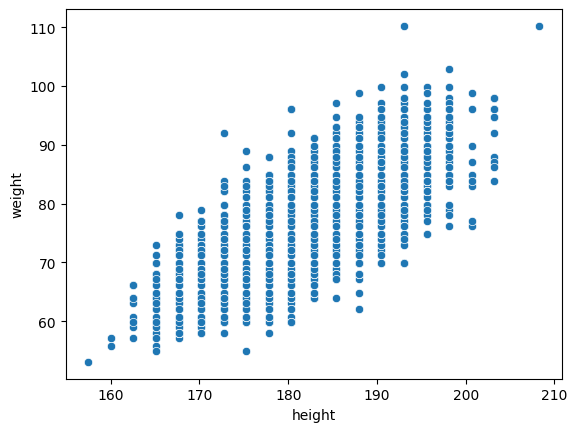

In [12]:
sns.scatterplot(data=player_without, x='height', y='weight');

We can see a couple of outliers that shouldn't make much of a difference.

Now let's calculate BMI so we can use this as one of players attributes later on. 

BMI formulA BMI = Weight (kg) / Height (m) 2

In [13]:
player['BMI'] = player['weight'] / (player['height']/100)**2

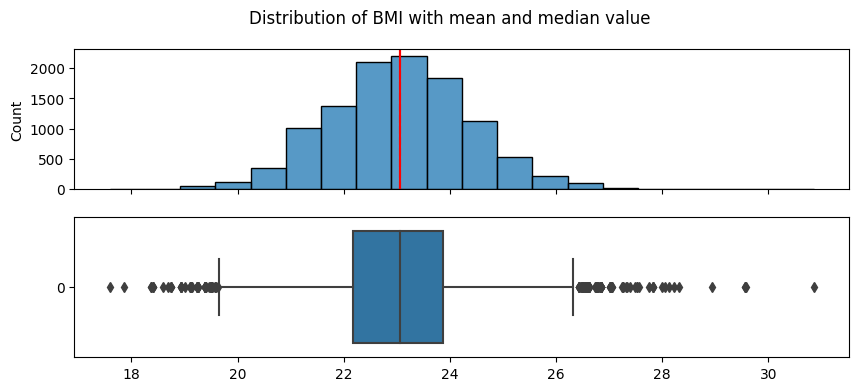

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 4))
sns.histplot(player['BMI'], bins=20, ax= ax1)
sns.boxplot(player['BMI'], orient='h', ax=ax2)
ax1.axvline(x=player['BMI'].mean(), color='r', linestyle='solid', label='BMI mean')
ax1.axvline(x=player['BMI'].median(), color='r', linestyle='dashed', label='BMI median')
plt.suptitle("Distribution of BMI with mean and median value");

In [15]:
player['BMI'].describe()[['mean', '50%']]

mean   23.07
50%    23.06
Name: BMI, dtype: float64

Both values are very close which means the outliers don't have significant impact. Taking into account the classification of BMI: 
* Less than 18.5 Underweight 
* 18.5 to 24.9 Healthy weight 
* 25 to 29.9 Overweight but not obese 
* 30 to 34.9 Obese class I
Most of the players are having healthy weight. There are a few with too low BMI and some overweighted and one obese player. We need to remember that the BMI indicator is accurate for general population. Not the population of players. 

## Players attributes

The atributes were taken from FIFA video game. Those are the player skills ranked between 0 and 99. The mean of those skills is represented in overall_rating. 

Excellent 90-99
very good 80-89
good 70-79
just at 50-69
needs imporvement 40-49
insufficient 0-39

Let's see the player attributes table.

In [16]:
pd.set_option('display.max_columns', 100)
pl_att = pd.read_sql('''select * from player_attributes''', conn, parse_dates='date')
pl_att.head(2)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18,67.00,71.00,right,medium,medium,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,71.00,70.00,45.00,54.00,48.00,65.00,69.00,69.00,6.00,11.00,10.00,8.00,8.00
1,2,218353,505942,2015-11-19,67.00,71.00,right,medium,medium,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,71.00,70.00,45.00,54.00,48.00,65.00,69.00,69.00,6.00,11.00,10.00,8.00,8.00


Let's check preferred foot.

Changing categories to numbers.

In [17]:
pl_att['attacking_work_rate'].value_counts().index

Index(['medium', 'high', 'low', 'None', 'norm', 'y', 'le', 'stoc'], dtype='object')

Replacing values of attacking_work_rate:

* medium, normal = 2
* low = 1
* high = 3
* None, y, stoc, le to np.nan

In [18]:
pl_att['attacking_work_rate'] = pl_att['attacking_work_rate'].replace(['None', 'y', 'stoc', 'le'], np.nan)
pl_att['attacking_work_rate'] = pl_att['attacking_work_rate'].replace({'medium': 2, 'norm': 2, 'low': 1, 'high': 3})
pl_att['attacking_work_rate'].value_counts()

2.00    125418
3.00     42823
1.00      8569
Name: attacking_work_rate, dtype: int64

Engineering of defensive_work_rate column:

In [19]:
pl_att['defensive_work_rate'].value_counts().index

Index(['medium', 'high', 'low', '_0', 'o', '1', 'ormal', '2', '3', '5', '7',
       '0', '6', '9', '4', 'es', 'ean', 'tocky', '8'],
      dtype='object')

Replace the 'o' and 'es' values with null and backfill.

We have scale from 0 to 10 which will be splitted into 3 categories:
* 0-3 = 1
* 4-6 = 2
* 7-10 = 3

Then:
* low = 1
* medium = 2
* high = 3

Then:
* lean = 1
* ormal = 2
* tocky = 3

In [20]:
pl_att['defensive_work_rate'] = pl_att['defensive_work_rate'].replace(['es', 'o', '_0'], np.nan)

In [21]:
dict_to_replace = {
    '0': 1, '1': 1, '2': 1,'3': 1, 'low': 1, 'ean': 1,
    '4': 2, '5': 2, '6': 2, 'medium': 2, 'ormal': 2,
    '7': 3, '8': 3, '9': 3, 'tocky': 3, 'high': 3
}
pl_att['defensive_work_rate'] = pl_att['defensive_work_rate'].replace(dict_to_replace)

In [22]:
pl_att['defensive_work_rate'].value_counts()

2.00    131741
3.00     27577
1.00     19774
Name: defensive_work_rate, dtype: int64

Creating dummies for foot preferences.

In [23]:
pl_att.reset_index()

,index,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,0,1,218353,505942,2016-02-18,67.00,71.00,right,2.00,2.00,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,71.00,70.00,45.00,54.00,48.00,65.00,69.00,69.00,6.00,11.00,10.00,8.00,8.00
1,1,2,218353,505942,2015-11-19,67.00,71.00,right,2.00,2.00,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,71.00,70.00,45.00,54.00,48.00,65.00,69.00,69.00,6.00,11.00,10.00,8.00,8.00
2,2,3,218353,505942,2015-09-21,62.00,66.00,right,2.00,2.00,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,63.00,41.00,45.00,54.00,48.00,65.00,66.00,69.00,6.00,11.00,10.00,8.00,8.00
3,3,4,218353,505942,2015-03-20,61.00,65.00,right,2.00,2.00,48.00,43.00,70.00,60.00,43.00,50.00,44.00,38.00,63.00,48.00,60.00,64.00,59.00,46.00,65.00,54.00,58.00,54.00,76.00,34.00,62.00,40.00,44.00,53.00,47.00,62.00,63.00,66.00,5.00,10.00,9.00,7.00,7.00
4,4,5,218353,505942,2007-02-22,61.00,65.00,right,2.00,2.00,48.00,43.00,70.00,60.00,43.00,50.00,44.00,38.00,63.00,48.00,60.00,64.00,59.00,46.00,65.00,54.00,58.00,54.00,76.00,34.00,62.00,40.00,44.00,53.00,47.00,62.00,63.00,66.00,5.00,10.00,9.00,7.00,7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,183973,183974,102359,39902,2009-08-30,83.00,85.00,right,2.00,1.00,84.00,77.00,59.00,89.00,77.00,84.00,86.00,78.00,84.00,85.00,66.00,72.00,77.00,86.00,73.00,76.00,58.00,72.00,67.00,81.00,56.00,78.00,86.00,88.00,83.00,22.00,31.00,30.00,9.00,20.00,84.00,20.00,20.00
183974,183974,183975,102359,39902,2009-02-22,78.00,80.00,right,2.00,1.00,74.00,76.00,53.00,84.00,77.00,85.00,86.00,74.00,73.00,86.00,66.00,67.00,77.00,74.00,73.00,75.00,58.00,66.00,65.00,73.00,61.00,64.00,72.00,88.00,70.00,32.00,31.00,30.00,9.00,20.00,73.00,20.00,20.00
183975,183975,183976,102359,39902,2008-08-30,77.00,80.00,right,2.00,1.00,74.00,71.00,53.00,84.00,77.00,85.00,86.00,74.00,73.00,86.00,66.00,67.00,77.00,74.00,73.00,75.00,58.00,66.00,65.00,73.00,67.00,64.00,72.00,88.00,70.00,32.00,31.00,30.00,9.00,20.00,73.00,20.00,20.00
183976,183976,183977,102359,39902,2007-08-30,78.00,81.00,right,2.00,1.00,74.00,64.00,57.00,86.00,77.00,87.00,86.00,73.00,73.00,91.00,61.00,60.00,77.00,69.00,73.00,72.00,58.00,67.00,59.00,78.00,63.00,63.00,68.00,88.00,53.00,28.00,32.00,30.00,9.00,20.00,73.00,20.00,20.00


In [24]:
pl_att = pd.concat([pl_att, pd.get_dummies(pl_att.preferred_foot, prefix='leg')], 1)

C:\Users\New_User\AppData\Local\Temp\ipykernel_16120\4256484886.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pl_att = pd.concat([pl_att, pd.get_dummies(pl_att.preferred_foot, prefix='leg')], 1)


In [25]:
pl_att.head(2)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,leg_left,leg_right
0,1,218353,505942,2016-02-18,67.00,71.00,right,2.00,2.00,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,71.00,70.00,45.00,54.00,48.00,65.00,69.00,69.00,6.00,11.00,10.00,8.00,8.00,0,1
1,2,218353,505942,2015-11-19,67.00,71.00,right,2.00,2.00,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,71.00,70.00,45.00,54.00,48.00,65.00,69.00,69.00,6.00,11.00,10.00,8.00,8.00,0,1


In [26]:
pl_att.drop(['preferred_foot', 'date'], axis=1, inplace=True)

In [27]:
pl_att = pl_att.sort_values(by=['potential', 'player_api_id']).fillna(method='ffill')

In [28]:
pl_att.isnull().sum().sum()

0

Reducing the dataframe to mean values for players.

In [29]:
player_att = pl_att.groupby(["player_fifa_api_id", 'player_api_id']).mean()
player_att.reset_index()

,player_fifa_api_id,player_api_id,id,overall_rating,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,leg_left,leg_right
0,2,39357,64709.50,70.60,71.10,2.33,2.23,74.10,48.03,62.80,71.20,56.57,66.60,67.73,60.60,69.20,70.37,71.90,75.17,67.97,71.23,67.43,70.83,68.03,77.07,71.37,65.20,76.53,74.07,65.10,55.77,59.77,71.47,74.00,72.83,13.30,7.63,26.00,11.77,13.47,1.00,0.00
1,6,41762,6773.50,72.12,76.25,2.00,2.00,18.00,18.00,24.00,28.75,6.50,17.00,7.25,15.38,55.25,17.25,47.50,47.50,48.00,68.00,64.88,36.00,72.00,50.00,60.75,14.75,35.00,36.75,30.38,42.00,25.25,24.75,24.12,17.00,71.75,72.38,71.00,75.25,72.75,0.00,1.00
2,11,26028,152816.00,67.35,69.41,2.00,3.00,63.59,54.35,60.88,71.88,64.47,67.12,69.06,51.00,66.76,72.47,59.88,56.65,69.29,65.94,63.71,75.35,67.29,68.59,75.18,70.41,62.06,59.88,63.12,68.88,68.12,45.12,49.59,58.94,6.00,7.06,13.94,7.47,11.88,0.00,1.00
3,16,24852,105636.50,74.12,76.56,2.19,1.94,74.19,73.94,64.00,68.75,72.62,76.12,77.56,76.75,56.44,80.31,76.50,78.12,77.06,71.38,72.00,74.88,71.25,76.12,70.56,73.94,69.06,34.00,75.81,59.88,75.75,27.06,31.06,21.00,9.25,13.62,24.25,12.94,12.56,0.00,1.00
4,27,30630,83337.50,76.50,77.60,2.80,1.53,80.93,69.83,49.83,80.13,76.83,82.33,83.33,76.80,68.43,83.47,64.17,61.57,77.30,71.77,78.07,73.57,59.13,47.60,60.63,73.23,68.20,44.67,73.93,81.37,67.70,37.13,36.20,29.33,8.33,7.67,21.77,16.03,8.33,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11064,233885,705484,50809.00,52.00,67.67,2.00,2.00,29.00,18.00,52.00,31.00,26.00,25.00,25.00,27.00,27.00,32.00,64.00,63.00,44.00,50.00,62.00,41.00,71.00,61.00,63.00,20.00,42.00,54.00,27.00,32.00,35.00,49.00,56.00,52.00,6.00,8.00,5.00,7.00,6.00,0.00,1.00
11065,233911,674492,88874.50,58.00,66.00,2.00,2.00,51.00,25.00,41.00,51.00,22.00,45.00,33.00,31.00,26.00,44.00,78.00,75.00,52.00,48.00,70.00,27.00,63.00,80.00,56.00,23.00,50.00,49.00,40.00,33.00,35.00,56.00,61.00,65.00,5.00,8.00,6.00,9.00,5.00,1.00,0.00
11066,233930,746419,58305.50,59.00,66.00,3.00,2.00,55.00,28.00,50.00,35.00,29.00,67.00,37.00,39.00,35.00,55.00,77.00,76.00,70.00,60.00,74.00,29.00,55.00,63.00,46.00,27.00,59.00,53.00,55.00,40.00,43.00,55.00,69.00,62.00,7.00,10.00,7.00,9.00,9.00,0.00,1.00
11067,233969,748432,60180.50,58.00,68.00,2.00,2.00,48.00,26.00,57.00,49.00,24.00,41.00,39.00,20.00,41.00,42.00,64.00,68.00,50.00,48.00,52.00,46.00,68.00,50.00,67.00,25.00,52.00,55.00,38.00,36.00,45.00,63.00,69.00,68.00,8.00,8.00,12.00,12.00,6.00,0.00,1.00


Now we need to make sure that columns for legs have either 1 or 0. 

In [30]:
def foot(row):
    
    if row > 0.5:
        return 1
    else:
        return 0

In [31]:
player_att['leg_left'] = player_att['leg_left'].apply(foot)
player_att['leg_right'] = player_att['leg_right'].apply(foot)

Now we have a dataframe with all the attributes of the players. We can also add BMI and birthday to have full set of information. We will marge those datasets and then store as a new table.

In [32]:
player_att_clean = player.merge(player_att, on='player_api_id')
player_att_clean.drop(['height', 'weight', 'id'], axis=1, inplace=True)
player_att_clean.head(2)

,player_api_id,player_name,birthday,BMI,overall_rating,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,leg_left,leg_right
0,505942,Aaron Appindangoye,1992,25.36,63.60,67.60,2.00,2.00,48.60,43.60,70.60,60.60,43.60,50.60,44.60,38.60,63.60,48.60,60.00,64.00,59.00,46.60,65.00,54.60,58.00,54.00,76.00,34.60,65.80,52.20,44.60,53.60,47.60,63.80,66.00,67.80,5.60,10.60,9.60,7.60,7.60,0,1
1,155782,Aaron Cresswell,1989,22.87,66.97,74.48,2.21,2.00,70.79,49.45,52.94,62.27,29.15,61.09,61.88,62.12,63.24,61.79,76.00,74.94,75.24,67.85,84.73,65.91,75.30,72.88,51.76,54.12,65.06,57.88,51.48,57.45,53.12,69.39,68.79,71.52,12.18,8.67,14.24,10.36,12.91,1,0


In [33]:
# player_att_clean.to_sql('player_attributes_cleaned', conn)

## Country

In [34]:
country = pd.read_sql('''select * from country''', conn)
country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


We have 11 countries to consider. 

## League

In [35]:
league = pd.read_sql('''select * from league''', conn)
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


Let's check which leagues are in which countries?

In [36]:
c_league = pd.read_sql('''select l.name league, c.name country from league l join country c on c.id=l.country_id ''', conn)
c_league

,league,country
0,Belgium Jupiler League,Belgium
1,England Premier League,England
2,France Ligue 1,France
3,Germany 1. Bundesliga,Germany
4,Italy Serie A,Italy
5,Netherlands Eredivisie,Netherlands
6,Poland Ekstraklasa,Poland
7,Portugal Liga ZON Sagres,Portugal
8,Scotland Premier League,Scotland
9,Spain LIGA BBVA,Spain


## Match

In [37]:
match = pd.read_sql('''select * from match''', conn, parse_dates='date')
match.head(2)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,...,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.20,3.50,1.80,3.30,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.30,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.20,3.50,1.90,3.20,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.30,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60


Countplots for home and away goals. 

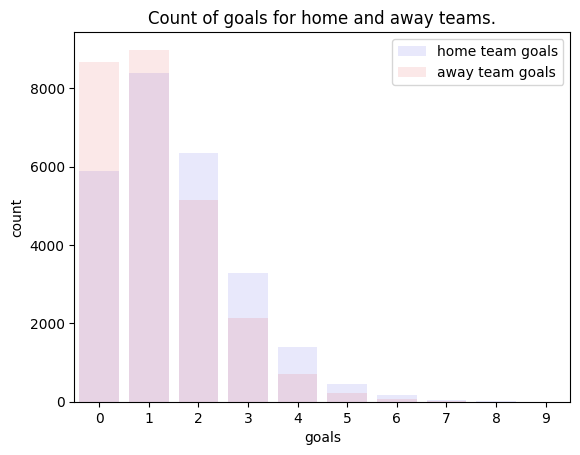

In [38]:
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.countplot(x="home_team_goal", data=match, color='b', alpha=0.1, label='home team goals') #ax=ax1)
sns.countplot(x="away_team_goal", data=match, color='r', alpha=0.1, label='away team goals'), # ax=ax2)
plt.legend()
plt.xlabel('goals')
plt.title('Count of goals for home and away teams.');

Straigh away we see that the count of goals for home and away is different. Away teams were more prone to get the lower number of goals than the home team. 

Assigning victory and punctation to see which teams got the highiest scores through the years.

In [39]:
def punctation_home(row):
    
    pkt_diff = row["home_team_goal"] - row["away_team_goal"]
    
    if pkt_diff == 0:
        return 1
    elif pkt_diff > 0:
        return 3
    else:
        return 0

In [40]:
match['home_team_pkt'] = match.apply(punctation_home, axis=1)

In [41]:
def punctation_away(row):
    
    pkt_diff = row["home_team_goal"] - row["away_team_goal"]
    
    # for draw
    if pkt_diff == 0:
        return 1
    # for won
    elif pkt_diff < 0:
        return 3
    # for loss
    else:
        return 0

In [42]:
match["away_team_pkt"] = match.apply(punctation_away, axis=1)

Adding column of home team results. 

In [43]:
def home_won(row):
    
    if row['home_team_pkt'] == 1:
        return 'Draw'
    elif row['home_team_pkt'] == 0:
        return 'Loss'
    else:
        return 'Won'

In [44]:
match['home_result'] = match.apply(home_won, axis=1)

Removing columns with html values.

In [45]:
columns_html = ['goal', 'shoton', 'shotoff', 'foulcommit', 'cross', 'corner', 'possession']

In [46]:
match.drop(columns_html, axis=1, inplace=True)

Season -> Start of season

Date -> Month

In [47]:
match['season_start'] = match['season'].apply(lambda x: int(x[:4]))

In [48]:
match['month'] = match['date'].dt.month

In [49]:
match.drop(['date', 'season'], axis=1, inplace=True)

In [50]:
match.head(2)

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,...,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,card,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_team_pkt,away_team_pkt,home_result,season_start,month
0,1,1,1,1,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.20,3.50,1.80,3.30,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.30,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,1,1,Draw,2008,8
1,2,1,1,1,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.20,3.50,1.90,3.20,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.30,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,1,1,Draw,2008,8


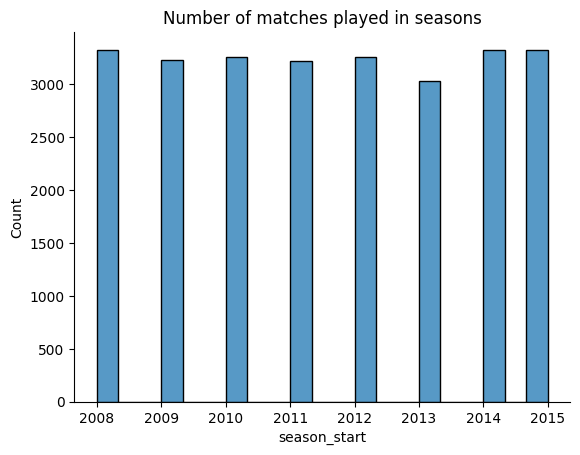

In [51]:
ax = sns.histplot(match['season_start'])
plt.title('Number of matches played in seasons')
sns.despine();

In [52]:
match['season_start'].value_counts().describe()

count      8.00
mean    3247.38
std       97.21
min     3032.00
25%     3227.50
50%     3260.00
75%     3325.25
max     3326.00
Name: season_start, dtype: float64

Each season the number of matches in a dataset was between 3032 and 3326. 

In [53]:
country.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [54]:
matches = match[["country_id","home_result"]].merge(country, left_on='country_id', right_on='id')
#.groupby(["name","home_result"]).count().drop('country_id', axis=1).rename({'id': 'count'}, axis=1)

In [55]:
outcome_country = pd.crosstab(matches['name'], matches['home_result'])
outcome_country['sum'] = outcome_country.apply(lambda x: sum(x), axis=1)

In [56]:
outcome_country.sort_values(by='sum', ascending=False)

home_result,Draw,Loss,Won,sum
name,,,,
England,783,867,1390,3040
France,859,822,1359,3040
Spain,704,851,1485,3040
Italy,796,814,1407,3017
Germany,597,744,1107,2448
Netherlands,581,696,1171,2448
Portugal,533,611,908,2052
Poland,525,525,870,1920
Scotland,447,617,760,1824


In [57]:
pd.crosstab(matches['name'], matches['home_result']).apply(lambda x: x/sum(x), axis=1)

home_result,Draw,Loss,Won
name,,,
Belgium,0.25,0.29,0.47
England,0.26,0.29,0.46
France,0.28,0.27,0.45
Germany,0.24,0.30,0.45
Italy,0.26,0.27,0.47
Netherlands,0.24,0.28,0.48
Poland,0.27,0.27,0.45
Portugal,0.26,0.30,0.44
Scotland,0.25,0.34,0.42


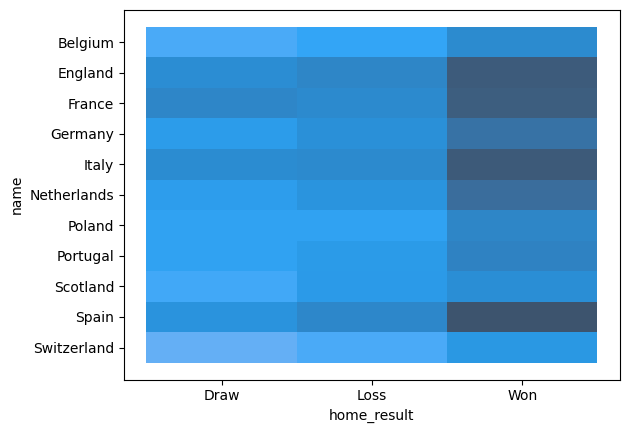

In [58]:
g = sns.histplot(y="name", x='home_result',data=matches)


From the histogram we see that clearly the home advantage.

Cleaning the betting houses data. For the betting houses we see entries: B365H
B365D
B365A
BWH
BWD
BWA
IWH
IWD
IWA
LBH
LBD
LBA
PSH
PSD
PSA
WHH
WHD
WHA
SJH
SJD
SJA
VCH
VCD
VCA
GBH
GBD
GBA
BSH
BSD
BSA

All betting houses are betting on odds on home team, away team won or draw. We will produce new columns with average betts and later remove those columns. 

In [59]:
betting_houses = ['B365',
'BW',
'IW',
'LB',
'PS',
'WH',
'SJ',
'VC',
'GB',
'BS']

In [60]:
def average_odds(row, odds_for: str, betting_houses=betting_houses):

    '''Calculates average odds from all betting companies for either home win, away win or draw.
    odds_for: A for Away Win, H for Home Win, D for Draw'''

    odds_count = 0
    odds_sum = 0
    for accronyme in betting_houses:
        column = accronyme + odds_for
        if pd.isna(row[column]) == False:
            odds_sum += row[column]
            odds_count +=1
            
    # Avoiding ZeroDevisionError
    if odds_count == 0:
        odds_count = 1
        
    return odds_sum/odds_count

In [61]:
match['odds_away'] = match.apply(lambda x: average_odds(x, 'A'), axis=1)
match['odds_house'] = match.apply(lambda x: average_odds(x, 'H'), axis=1)
match['odds_draw'] = match.apply(lambda x: average_odds(x, 'D'), axis=1)

In [62]:
match['away'] = match['odds_away']/(match['odds_away'] + match['odds_house'] + match['odds_draw'])
match['house'] = match['odds_house']/(match['odds_away'] + match['odds_house'] + match['odds_draw'])
match['draw'] = match['odds_draw']/(match['odds_away'] + match['odds_house'] + match['odds_draw'])

Removing betting houses. 

In [63]:
betting_columns_remove = [house + bet for house in betting_houses for bet in ['A', 'H', 'D']]
match.drop(columns=betting_columns_remove, inplace=True)

We will also remove the columns with coordinates of players position in formation.

In [64]:
position_columns = [ha + "_player_" + axis + str(number) 
                    for ha in ['away', 'home']
                    for axis in ['X', 'Y']
                    for number in range(1, 12)
                   ]

In [65]:
match.drop(columns=position_columns, axis=1, inplace=True)

In [66]:
match.shape

(25979, 43)

In [67]:
to_pred = match[['odds_away', 'odds_house', 'odds_draw', 'away', 'house', 'draw', 'home_result']]
to_pred.head()

,odds_away,odds_house,odds_draw,away,house,draw,home_result
0,4.16,1.77,3.32,0.45,0.19,0.36,Draw
1,3.62,1.90,3.25,0.41,0.22,0.37,Draw
2,2.54,2.46,3.23,0.31,0.30,0.39,Loss
3,6.53,1.44,3.81,0.55,0.12,0.32,Won
4,1.67,4.49,3.42,0.17,0.47,0.36,Loss


In [68]:
to_pred.dropna(inplace=True)
X = to_pred[['away', 'house', 'draw']]
y = to_pred['home_result']

from sklearn import datasets, neighbors, linear_model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression(max_iter=1000)

print("KNN score: %f" % knn.fit(X_train, y_train).score(X_test, y_test))
print(
    "LogisticRegression score: %f"
    % logistic.fit(X_train, y_train).score(X_test, y_test)
)


C:\Users\New_User\AppData\Local\Temp\ipykernel_16120\2013647248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_pred.dropna(inplace=True)


KNN score: 0.450255
LogisticRegression score: 0.539555


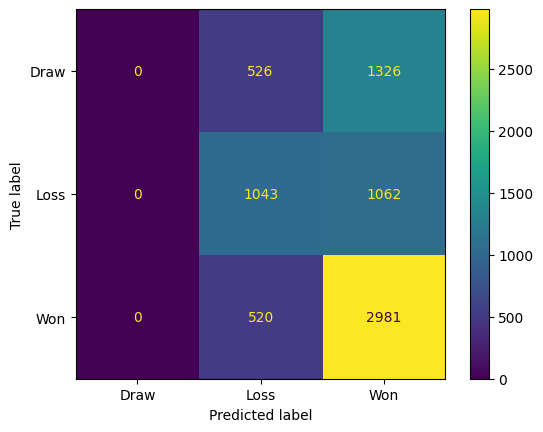

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = logistic.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [70]:
match.head(2)

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,card,home_team_pkt,away_team_pkt,home_result,season_start,month,odds_away,odds_house,odds_draw,away,house,draw
0,1,1,1,1,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,1,1,Draw,2008,8,4.16,1.77,3.32,0.45,0.19,0.36
1,2,1,1,1,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,1,1,Draw,2008,8,3.62,1.90,3.25,0.41,0.22,0.37


In [71]:
#match.drop(['league_id', 'id', 'country_id', 'match_api_id'], axis=1).to_sql('match_cleaned', conn)

ValueError: Table 'match_cleaned' already exists.

## Team

In [72]:
team = pd.read_sql('''select * from team''', conn)

Let's check the overall information about the table.

In [73]:
team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                296 non-null    int64  
 1   team_api_id       296 non-null    int64  
 2   team_fifa_api_id  285 non-null    float64
 3   team_long_name    296 non-null    object 
 4   team_short_name   296 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.7+ KB


We can see that there are 11 missing values in team_fifa_api_id. Most likely we won't need this column at all so leave it as it is at the moment. 
The duplicates were permanently removed with the following code:

In [74]:
# Quick check 
pd.read_sql('''select home_team_api_id from match where home_team_api_id in (274581, 8020, 8024)''', conn)

,home_team_api_id


now we can remove those entries from our database

In [75]:
cursor.execute('''delete from team where id=? ''', (2510,))
cursor.execute('''delete from team where id=? ''', (31445,))
cursor.execute('''delete from team where id=? ''', (32409,))
conn.commit()

In this table both team_fifa_api_id, id and team_short_name are insignificant so we can drop those columns

In [76]:
team.drop(columns=['id', 'team_fifa_api_id'], axis=1, inplace=True)

In [77]:
team.head()

,team_api_id,team_long_name,team_short_name
0,9987,KRC Genk,GEN
1,9993,Beerschot AC,BAC
2,10000,SV Zulte-Waregem,ZUL
3,9994,Sporting Lokeren,LOK
4,9984,KSV Cercle Brugge,CEB


## Team attributes

In [78]:
team_att = pd.read_sql('''select * from team_attributes''', conn, parse_dates='date')

In [79]:
team_att.shape

(1458, 25)

In [80]:
team_att.columns

Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')

In [81]:
team_att.drop(columns=['id', 'team_fifa_api_id'], axis=1, inplace=True)

In [82]:
team_att['month'] = team_att['date'].dt.month
team_att['year'] = team_att['date'].dt.year
team_att[['year', 'month']].dtypes

year     int64
month    int64
dtype: object

In [83]:
def sezon_start(row):
    
    if row['month'] >= 8:
        return row['year']
    else:
        return row['year'] - 1


def extract_sezon(df):
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    df['sezon_start'] = df.apply(sezon_start, axis=1)
    df.drop(['month', 'year', 'date'], axis=1, inplace= True)
    return df

In [84]:
team_att['sezon_start'] = team_att.apply(sezon_start, axis=1)

In [85]:
team_att[['month', 'year', 'date', 'sezon_start']].head(2)

,month,year,date,sezon_start
0,2,2010,2010-02-22,2009
1,9,2014,2014-09-19,2014


In [86]:
team_att.drop(columns=['month', 'year', 'date'], inplace=True)


In [87]:
team_att.shape

(1458, 23)

In [88]:
team_att.isnull().sum()

team_api_id                         0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
sezon_start                         0
dtype: int64

In [89]:
team_att.drop('buildUpPlayDribbling', axis=1, inplace=True)

In [90]:
team_att.dtypes

team_api_id                        int64
buildUpPlaySpeed                   int64
buildUpPlaySpeedClass             object
buildUpPlayDribblingClass         object
buildUpPlayPassing                 int64
buildUpPlayPassingClass           object
buildUpPlayPositioningClass       object
chanceCreationPassing              int64
chanceCreationPassingClass        object
chanceCreationCrossing             int64
chanceCreationCrossingClass       object
chanceCreationShooting             int64
chanceCreationShootingClass       object
chanceCreationPositioningClass    object
defencePressure                    int64
defencePressureClass              object
defenceAggression                  int64
defenceAggressionClass            object
defenceTeamWidth                   int64
defenceTeamWidthClass             object
defenceDefenderLineClass          object
sezon_start                        int64
dtype: object

Checking for categorical and numerical columns and printing unique values of categorical columns.

In [91]:
categorical_columns = []
numerical_columns = []
print('Unique values of categorical columns: ')
for column in team_att.columns:
    if team_att[column].dtype == 'object':
        categorical_columns.append(column)
        print(team_att[column].unique())
    else:
        numerical_columns.append(column)

Unique values of categorical columns: 
['Balanced' 'Fast' 'Slow']
['Little' 'Normal' 'Lots']
['Mixed' 'Long' 'Short']
['Organised' 'Free Form']
['Normal' 'Risky' 'Safe']
['Normal' 'Lots' 'Little']
['Normal' 'Lots' 'Little']
['Organised' 'Free Form']
['Medium' 'Deep' 'High']
['Press' 'Double' 'Contain']
['Normal' 'Wide' 'Narrow']
['Cover' 'Offside Trap']


In [92]:
categorical = pd.get_dummies(team_att[categorical_columns]).reset_index()
categorical.head()

,index,buildUpPlaySpeedClass_Balanced,buildUpPlaySpeedClass_Fast,buildUpPlaySpeedClass_Slow,buildUpPlayDribblingClass_Little,buildUpPlayDribblingClass_Lots,buildUpPlayDribblingClass_Normal,buildUpPlayPassingClass_Long,buildUpPlayPassingClass_Mixed,buildUpPlayPassingClass_Short,buildUpPlayPositioningClass_Free Form,buildUpPlayPositioningClass_Organised,chanceCreationPassingClass_Normal,chanceCreationPassingClass_Risky,chanceCreationPassingClass_Safe,chanceCreationCrossingClass_Little,chanceCreationCrossingClass_Lots,chanceCreationCrossingClass_Normal,chanceCreationShootingClass_Little,chanceCreationShootingClass_Lots,chanceCreationShootingClass_Normal,chanceCreationPositioningClass_Free Form,chanceCreationPositioningClass_Organised,defencePressureClass_Deep,defencePressureClass_High,defencePressureClass_Medium,defenceAggressionClass_Contain,defenceAggressionClass_Double,defenceAggressionClass_Press,defenceTeamWidthClass_Narrow,defenceTeamWidthClass_Normal,defenceTeamWidthClass_Wide,defenceDefenderLineClass_Cover,defenceDefenderLineClass_Offside Trap
0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0
1,1,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0
2,2,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0
3,3,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0
4,4,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0


In [93]:
numerical = team_att[numerical_columns].reset_index()
numerical.head()

,index,team_api_id,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,sezon_start
0,0,9930,60,50,60,65,55,50,55,45,2009
1,1,9930,52,56,54,63,64,47,44,54,2014
2,2,9930,47,54,54,63,64,47,44,54,2015
3,3,8485,70,70,70,70,70,60,70,70,2009
4,4,8485,47,52,53,48,52,47,47,52,2010


Box plots for numerical features. We need to remove columns that won't interest us. 

In [94]:
# Create the figure and two subplots
for col in ['team_api_id', 'sezon_start']: 
    numerical_columns.remove(col)

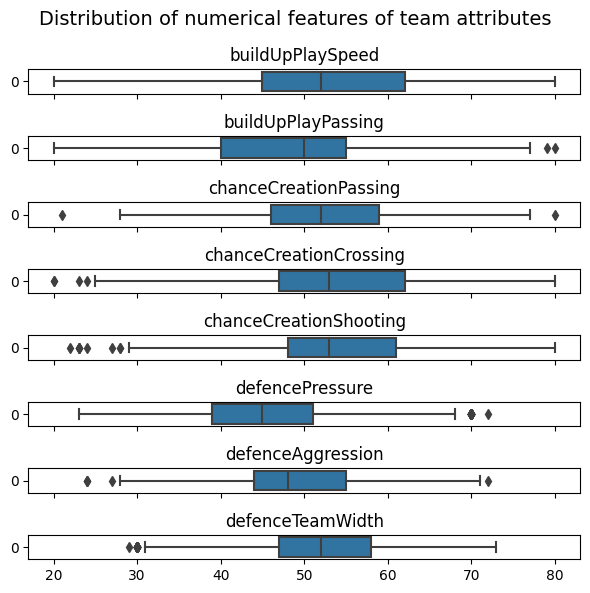

In [95]:

fig, axes = plt.subplots(nrows=len(numerical_columns), figsize=(6, 6), sharex=True)
fig.suptitle("Distribution of numerical features of team attributes", fontsize=14)

# Create the boxplot with Seaborn
for column, axis in zip(numerical_columns, axes):
    sns.boxplot(data=team_att[column], orient="h", ax=axis)
    axis.set_title(column)

# Show the plot
plt.tight_layout()
plt.show()

In [96]:
team_att = numerical.merge(categorical, on='index')
team_att.shape

(1458, 44)

Grouping on team and seazon start to calculate mean values. 

In [97]:
team_att = team_att.groupby(['team_api_id', 'sezon_start']).mean().drop('index', axis=1)
team_att.head(2)

buildUpPlaySpeed  buildUpPlayPassing  \
team_api_id sezon_start                                         
1601        2009                    30.00               40.00   
            2010                    48.00               51.00   

                         chanceCreationPassing  chanceCreationCrossing  \
team_api_id sezon_start                                                  
1601        2009                         50.00                   35.00   
            2010                         68.00                   67.00   

                         chanceCreationShooting  defencePressure  \
team_api_id sezon_start                                            
1601        2009                          70.00            65.00   
            2010                          51.00            46.00   

                         defenceAggression  defenceTeamWidth  \
team_api_id sezon_start                                        
1601        2009                     60.00             50.00   
            2010                     48.00             50.00   

                         buildUpPlaySpeedClass_Balanced  \
team_api_id sezon_start                                   
1601        2009                                   0.00   
            2010                                   1.00   

                         buildUpPlaySpeedClass_Fast  \
team_api_id sezon_start                               
1601        2009                               0.00   
            2010                               0.00   

                         buildUpPlaySpeedClass_Slow  \
team_api_id sezon_start                               
1601        2009                               1.00   
            2010                               0.00   

                         buildUpPlayDribblingClass_Little  \
team_api_id sezon_start                                     
1601        2009                                     1.00   
            2010                                     1.00   

                         buildUpPlayDribblingClass_Lots  \
team_api_id sezon_start                                   
1601        2009                                   0.00   
            2010                                   0.00   

                         buildUpPlayDribblingClass_Normal  \
team_api_id sezon_start                                     
1601        2009                                     0.00   
            2010                                     0.00   

                         buildUpPlayPassingClass_Long  \
team_api_id sezon_start                                 
1601        2009                                 0.00   
            2010                                 0.00   

                         buildUpPlayPassingClass_Mixed  \
team_api_id sezon_start                                  
1601        2009                                  1.00   
            2010                                  1.00   

                         buildUpPlayPassingClass_Short  \
team_api_id sezon_start                                  
1601        2009                                  0.00   
            2010                                  0.00   

                         buildUpPlayPositioningClass_Free Form  \
team_api_id sezon_start                                          
1601        2009                                          0.00   
            2010                                          0.00   

                         buildUpPlayPositioningClass_Organised  \
team_api_id sezon_start                                          
1601        2009                                          1.00   
            2010                                          1.00   

                         chanceCreationPassingClass_Normal  \
team_api_id sezon_start                                      
1601        2009                                      1.00   
            2010                                      0.00   

                         chanceCreationPassingClass_Risky

In [98]:
team_att.reset_index(inplace=True)

In [99]:
team_att['key'] = team_att['team_api_id'].astype(str) + team_att['sezon_start'].astype(str)

In [100]:
team_att.to_sql('team_attributes_cleaned', conn)

1454

Team attributes ready for analysis in table team_att_cleaned.

## Questions:
1) Which leagues score the most/fewest goals?
2) Who are the top scorers in each team and league?
3) Is there such a thing as home advantage?
4) Can we predict how many goals each team will score in each match?
5) Can we predict which team will win the match?

**Which league score the most/fewest goals?**

In [101]:
league_goals = pd.read_sql('''select distinct l.name, 
sum(m.home_team_goal + m.away_team_goal) over (partition by m.league_id) as goals
from match m
join league l 
on l.id=m.league_id
order by 2 desc''', conn)

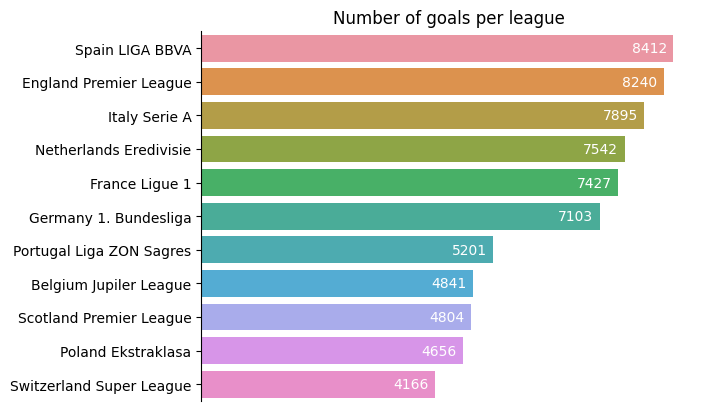

In [102]:
ax = sns.barplot(y=league_goals['name'], x=league_goals['goals'])
plt.bar_label(ax.containers[0], padding=-30, color='w')
plt.title('Number of goals per league')
sns.despine(bottom=True)
ax.set(xlabel='', xticks=[], ylabel='');

**Who are the top scorers in each team and league?**

In [103]:
pd.read_sql("""select t.team_long_name, l.name league, m.home_team_api_id
from team t
join match m
on m.home_team_api_id=t.team_api_id
join league l
on m.league_id=l.id""", conn).head()


,team_long_name,league,home_team_api_id
0,KRC Genk,Belgium Jupiler League,9987
1,SV Zulte-Waregem,Belgium Jupiler League,10000
2,KSV Cercle Brugge,Belgium Jupiler League,9984
3,KAA Gent,Belgium Jupiler League,9991
4,FCV Dender EH,Belgium Jupiler League,7947


In [104]:
playepd.read_sql('''select p.player_name, p.player_api_id, AVG(pa.overall_rating) overall_rating from player p
join player_attributes pa
on p.player_api_id=pa.player_api_id
group by 1, 2
order by 3 desc''', conn).head()

NameError: name 'playepd' is not defined

In [105]:
pd.read_sql('''select distinct p.player_api_id, m.home_team_api_id
from player p
join match m
on p.player_api_id=m.home_player_1 
or p.player_api_id= m.home_player_2
or p.player_api_id=m.home_player_3
or p.player_api_id=m.home_player_4
or p.player_api_id=m.home_player_5 
or p.player_api_id= m.home_player_6
or p.player_api_id=m.home_player_7
or p.player_api_id=m.home_player_8
or p.player_api_id= m.home_player_9
or p.player_api_id=m.home_player_10
or p.player_api_id=m.home_player_11
''', conn)

,player_api_id,home_team_api_id
0,39890,9996
1,38788,9996
2,38312,9996
3,26235,9996
4,26916,9996
...,...,...
18475,614540,9956
18476,705484,9931
18477,726956,9931
18478,531309,9824


In [106]:
players_team = pd.read_sql('''
select distinct t2.player_name, t2.overall_rating, t3.team_long_name, t3.league
from 
(select distinct p.player_api_id, m.home_team_api_id
from player p
join match m
on p.player_api_id=m.home_player_1 
or p.player_api_id= m.home_player_2
or p.player_api_id=m.home_player_3
or p.player_api_id=m.home_player_4
or p.player_api_id=m.home_player_5 
or p.player_api_id= m.home_player_6
or p.player_api_id=m.home_player_7
or p.player_api_id=m.home_player_8
or p.player_api_id= m.home_player_9
or p.player_api_id=m.home_player_10
or p.player_api_id=m.home_player_11) t1
left join
(select p.player_name, p.player_api_id, AVG(pa.overall_rating) overall_rating from player p
join player_attributes pa
on p.player_api_id=pa.player_api_id
group by 1, 2) t2
on t1.player_api_id=t2.player_api_id
join
(select t.team_long_name, l.name league, m.home_team_api_id
from team t
join match m
on m.home_team_api_id=t.team_api_id
join league l
on m.league_id=l.id) t3
on t1.home_team_api_id=t3.home_team_api_id
order by 2 desc''', conn)

In [107]:
players_team.to_sql('players_team', conn)

ValueError: Table 'players_team' already exists.

Let's take 3 best players from each league. 

In [108]:
pd.read_sql('''select * 
from
(select player_name, overall_rating, team_long_name, league, 
row_number() over (partition by league) rank
from players_team)
where rank in (1, 2, 3)''', conn)

,player_name,overall_rating,team_long_name,league,rank
0,Victor Valdes,83.64,Standard de Liège,Belgium Jupiler League,1
1,Mbark Boussoufa,79.69,RSC Anderlecht,Belgium Jupiler League,2
2,Kevin de Bruyne,78.89,KRC Genk,Belgium Jupiler League,3
3,Cristiano Ronaldo,91.28,Manchester United,England Premier League,1
4,Wayne Rooney,87.22,Manchester United,England Premier League,2
5,David Silva,86.54,Manchester City,England Premier League,3
6,Zlatan Ibrahimovic,88.29,Paris Saint-Germain,France Ligue 1,1
7,Karim Benzema,84.50,Olympique Lyonnais,France Ligue 1,2
8,Thiago Silva,83.92,Paris Saint-Germain,France Ligue 1,3
9,Franck Ribery,88.46,FC Bayern Munich,Germany 1. Bundesliga,1


**Can we predict how many goals each team will score in each match?**

Let's see how accurate we may be about predicting how many goals scorred home team and away team. For this we will get the attributes of each team and predictions from betting houses.  

In [109]:
match.columns

Index(['id', 'country_id', 'league_id', 'stage', 'match_api_id',
       'home_team_api_id', 'away_team_api_id', 'home_team_goal',
       'away_team_goal', 'home_player_1', 'home_player_2', 'home_player_3',
       'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
       'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9', 'away_player_10', 'away_player_11', 'card',
       'home_team_pkt', 'away_team_pkt', 'home_result', 'season_start',
       'month', 'odds_away', 'odds_house', 'odds_draw', 'away', 'house',
       'draw'],
      dtype='object')

In [110]:
columns_from_match = ['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal','season_start',
       'month', 'odds_away', 'odds_house', 'odds_draw', 'away', 'house',
       'draw']

In [111]:
match = match[columns_from_match]
match['key'] = match['home_team_api_id'].astype(str) + match['season_start'].astype(str)
match.to_sql('match_home', conn)

25979

In [115]:
pd.read_sql('''select * from team_attributes_cleaned''', conn).columns

Index(['index', 'team_api_id', 'sezon_start', 'buildUpPlaySpeed',
       'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing',
       'chanceCreationShooting', 'defencePressure', 'defenceAggression',
       'defenceTeamWidth', 'buildUpPlaySpeedClass_Balanced',
       'buildUpPlaySpeedClass_Fast', 'buildUpPlaySpeedClass_Slow',
       'buildUpPlayDribblingClass_Little', 'buildUpPlayDribblingClass_Lots',
       'buildUpPlayDribblingClass_Normal', 'buildUpPlayPassingClass_Long',
       'buildUpPlayPassingClass_Mixed', 'buildUpPlayPassingClass_Short',
       'buildUpPlayPositioningClass_Free Form',
       'buildUpPlayPositioningClass_Organised',
       'chanceCreationPassingClass_Normal', 'chanceCreationPassingClass_Risky',
       'chanceCreationPassingClass_Safe', 'chanceCreationCrossingClass_Little',
       'chanceCreationCrossingClass_Lots',
       'chanceCreationCrossingClass_Normal',
       'chanceCreationShootingClass_Little',
       'chanceCreationShootingClass_Lot

In [128]:
pd.read_sql('''select * from match_home where season_start=2008''', conn).head()

,index,home_team_api_id,away_team_api_id,home_team_goal,season_start,month,odds_away,odds_house,odds_draw,away,house,draw,key
0,0,9987,9993,1,2008,8,4.16,1.77,3.32,0.45,0.19,0.36,99872008
1,1,10000,9994,0,2008,8,3.62,1.90,3.25,0.41,0.22,0.37,100002008
2,2,9984,8635,0,2008,8,2.54,2.46,3.23,0.31,0.30,0.39,99842008
3,3,9991,9998,5,2008,8,6.53,1.44,3.81,0.55,0.12,0.32,99912008
4,4,7947,9985,1,2008,8,1.67,4.49,3.42,0.17,0.47,0.36,79472008


In [136]:
df = pd.read_sql('''select m.month, m.odds_away, m.odds_house, m.odds_draw, m.away, m.house, m.draw,
t.buildUpPlaySpeed,
       t.buildUpPlayPassing, t.chanceCreationPassing, t.chanceCreationCrossing,
       t.chanceCreationShooting, t.defencePressure, t.defenceAggression,
       m.home_team_goal
       from match_home m
       
       join team_attributes_cleaned t
       on m.home_team_api_id=t.team_api_id
       where not odds_away= 0 and odds_away is not null and season_start=2013''', conn)

In [137]:
df.home_team_goal.value_counts()

1    4643
2    3609
0    3240
3    1971
4     946
5     260
6      87
7      30
Name: home_team_goal, dtype: int64

In [138]:
df.columns

Index(['month', 'odds_away', 'odds_house', 'odds_draw', 'away', 'house',
       'draw', 'buildUpPlaySpeed', 'buildUpPlayPassing',
       'chanceCreationPassing', 'chanceCreationCrossing',
       'chanceCreationShooting', 'defencePressure', 'defenceAggression',
       'home_team_goal'],
      dtype='object')

In [143]:
X = df.drop(['home_team_goal'], axis=1)
y = np.array(df['home_team_goal']).reshape(-1, 1)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
X = StandardScaler().fit_transform(X)

model = LinearRegression()
model.fit(X, y)
model.score(X, y)

0.1688356169757812

In [172]:
df = pd.read_sql('''select * from match where corner is not null''', conn)

In [174]:
df['corner'].unique()

array(['<corner><value><stats><corners>1</corners></stats><event_incident_typefk>329</event_incident_typefk><elapsed>19</elapsed><subtype>cross</subtype><player1>38807</player1><sortorder>0</sortorder><team>10261</team><n>280</n><type>corner</type><id>378960</id></value><value><stats><corners>1</corners></stats><event_incident_typefk>330</event_incident_typefk><elapsed>22</elapsed><subtype>short</subtype><player1>40565</player1><sortorder>0</sortorder><team>10261</team><n>263</n><type>corner</type><id>378992</id></value><value><stats><corners>1</corners></stats><event_incident_typefk>329</event_incident_typefk><elapsed>22</elapsed><subtype>cross</subtype><player1>38807</player1><sortorder>4</sortorder><team>10261</team><n>293</n><type>corner</type><id>378996</id></value><value><stats><corners>1</corners></stats><event_incident_typefk>329</event_incident_typefk><elapsed>48</elapsed><subtype>cross</subtype><player1>24154</player1><sortorder>2</sortorder><team>10260</team><n>300</n><type>

In [162]:
len('<corner><value><stats><corners>')

31

In [177]:
def getting_number(row):
    
        return row[1]

In [200]:
df['cornerrr'] = df['corner'].apply(lambda x: x[3])

In [201]:
df['cornerrr'].value_counts()

r    14217
Name: cornerrr, dtype: int64